# "Titanic: Machine Learning from Disaster"

Por: João Pedro da Costa Loureiro.

Este notebook tem como objetivo analizar dados sobre o naufrágio do Titanic e desenvolver um modelo de Machine Learning que irá prever quais passageiros sobreviveriam ao acidente. Os dados fazem parte da competição "Titanic: Machine Learning from Disaster" do site Kaggle: https://www.kaggle.com/c/titanic/overview.


**O objetivo é alcançar uma precisão superior a 80%.**


A análise se dividirá em:

1. Importação dos dados e bibliotecas


2. Tratando valores missing

    2.1 Cabin
    
    2.2 Age
    
    2.3 Embarked
    

3. Análise exploratória

    3.1 Coluna 'Age'
    
    3.2 Coluna 'Fare'
    
    
4. Feature Engineering

    4.1 Category Age
    
    4.2 Have Family
    
    4.3 Title
    
    4.4 Deck
    
    4.5 Fare
    

5. Pré-processamento dos dados


6. Treinamento e validação do modelo

## Importação dos dados e bibliotecas

In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
# Importando os datasets
trainDF = pd.read_csv('train.csv')
trainDF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


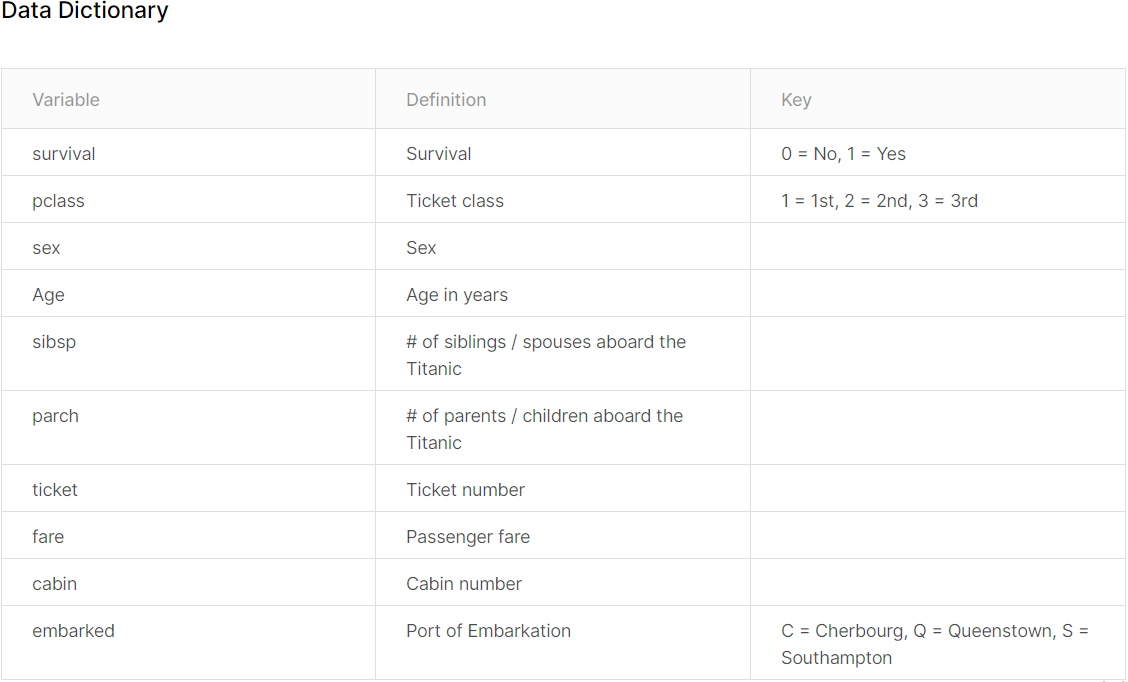

In [3]:
from IPython.display import Image
Image('Images\datadic.png')

In [4]:
trainDF.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Vamos identificar as colunas que possuem valores missing, bem como a porcentagem de valores missing.

In [5]:
def haveNan(df):
    '''Função que retorna lista com o nome das colunas que possuem valores missing
    e suas respectivas porcentagens e quantidades.'''
    
    nanCols = [] # Lista com nome de colunas com valores missing
    for column in df.columns:
        if True in df[column].isna().unique():
            nan_count = df[column].isna().value_counts()[True]
            nan_percent = round((nan_count * 100) / len(df[column]), 2)
            nanCols.append((column, nan_percent, nan_count))

    return nanCols

In [6]:
nanCols = haveNan(trainDF) 
nanCols

[('Age', 19.87, 177), ('Cabin', 77.1, 687), ('Embarked', 0.22, 2)]

## Tratando valores missing

### Cabin

Na coluna 'Cabin' vamos substituir os valores Nan por 'Unknow', ou seja, desconhecido. Essa informação será usada mais adiante.

In [7]:
trainDF['Cabin'] = ['Unknow' if x is np.nan else x for x in trainDF['Cabin']]
trainDF.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknow,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknow,S


In [8]:
haveNan(trainDF)

[('Age', 19.87, 177), ('Embarked', 0.22, 2)]

### Age

Já para a coluna 'Age', ao invés de preenchermos os valores com a média de todas as idades, vamos agrupar os dados e em seguida calcular a média para cada grupo. Em seguida vamos preencher os valores missing de acordo com agrupamentos. A idéia aqui é usar dados com maior granularidade que a média simples. Vamos agrupar por Sexo e Classe.

In [9]:
mean_ages_grouped = trainDF.groupby(['Sex', 'Pclass']).mean().Age.map(lambda x : round(x,2))

print('Média de todas as idades: {}'.format(round(trainDF['Age'].mean()), 2))
mean_ages_grouped

Média de todas as idades: 30


Sex     Pclass
female  1         34.61
        2         28.72
        3         21.75
male    1         41.28
        2         30.74
        3         26.51
Name: Age, dtype: float64

Note que as idades agrupadas variam entre 21.75 e 41.28. Enquanto a média de todas as idades é 30. Com as médias das idades agrupadas, temos um ganho de informação!

Agora vamos substituir os valores missing pelas médias agrupadas.

In [10]:
trainDF['Age'] = trainDF.apply(lambda row : mean_ages_grouped[row.Sex][row.Pclass]
                                         if np.isnan(row.Age) else row.Age, axis=1)
trainDF.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknow,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknow,S


In [11]:
haveNan(trainDF)

[('Embarked', 0.22, 2)]

### Embarked

Esta coluna apresenta apenas dois registros com valores missing. Portanto, iremos remover estes registros do dataset.

In [12]:
trainDF['Embarked'].dropna(inplace=True)
haveNan(trainDF)

[]

## Análise Exploratória

Nesta seção iremos explorar a maneira como os dados se relacionam. Para tal, usaremos a biblioteca Seaborn para plotar alguns gráficos.

In [13]:
import seaborn as sns

### Coluna 'Age'

Inicialmente, vamos ver como a variável 'Age' (Idade) se comporta em relação à variável 'Survived' (Sobreviveu), agrupando-a por 'Pclass' (Classe).

Obs.: Survived = 0: não sobreviveu,
      Survived = 1: sobreviveu.

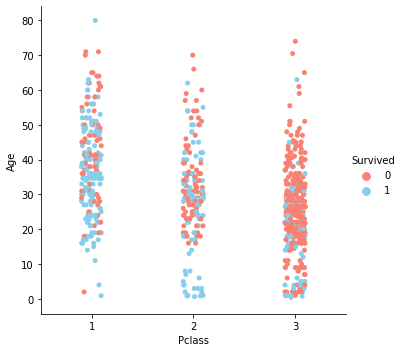

In [14]:
sns.catplot(x='Pclass', y='Age' ,hue='Survived',
           data=trainDF, palette={0:'salmon', 1:'skyblue'});

Analizando o gráfico acima podemos tirar algumas conclusões. A primeira é que a maioria das pessoas abaixo dos 10 anos de idade (Crianças) sobreviveram, especialmente as de 1ª e 2ª classe. Além disso, nota-se que uma boa parte das pessoas acima de 60 anos (Idosos) não sobreviveram. Por fim, há mais sobreviventes nas primeiras classes do que na 3ª.

Se além de agruparmos pela classe também agruparmos pelo sexo iremos ver que a maioria dos homens (Sex=male) não sobreviveram enquanto as mulheres (Sex=female) da 1ª e 2ª classe sobreviveram. 

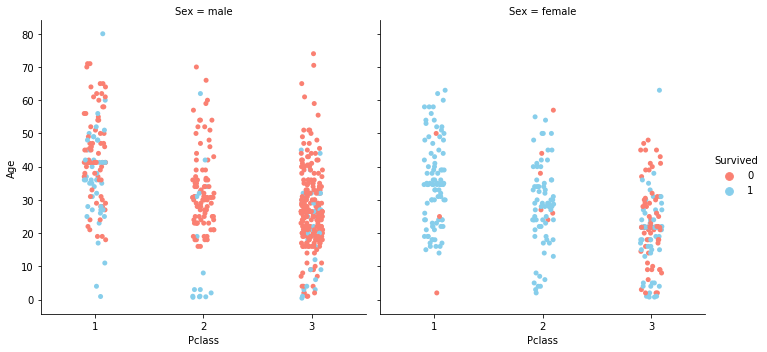

In [15]:
sns.catplot(x='Pclass', y='Age' ,hue='Survived', col='Sex',
           data=trainDF, palette={0:'salmon', 1:'skyblue'});

### Coluna 'Fare'

Vamos agrupar o preço das passagens em ranges e analizar seu comportamento.

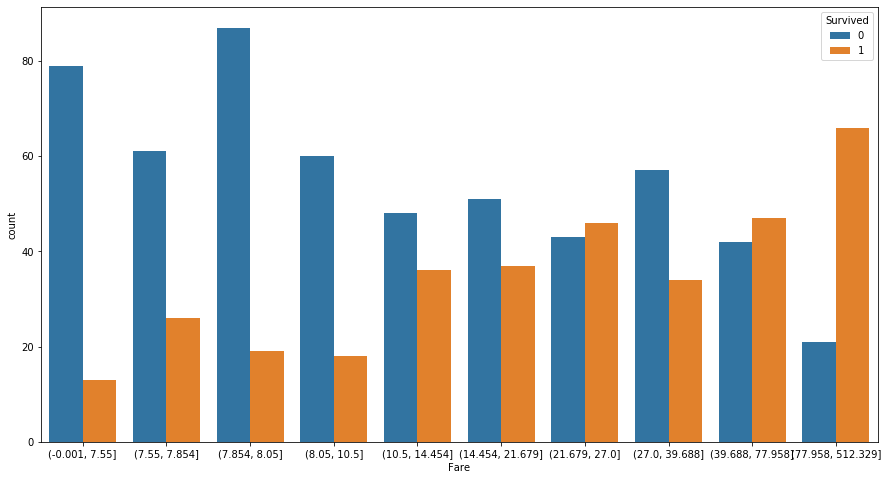

In [16]:
plt.figure(figsize=(15,8))
sns.countplot(x=pd.qcut(trainDF['Fare'], 10) ,data=trainDF, hue='Survived')
plt.show()

Podemos notar que quanto mais barato o Ticket, menor é a chance de sobreviver e quanto mais caro o Ticket, maior é a chace de sovreviver.

## Feature Engineering

### Category Age

Vamos dividir a coluna 'Age' em categorias: 0 <= age <= 10; 11 <= age < 60; 60 <= age.

In [17]:
def catAge(age):
    if age <= 10:
        cat = 'Children'
    elif age >= 60:
        cat = 'Old'
    else:
        cat = 'Adult'
    
    return cat

In [18]:
trainDF['Category_age'] = trainDF['Age'].map(catAge)
trainDF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Category_age
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknow,S,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknow,S,Adult


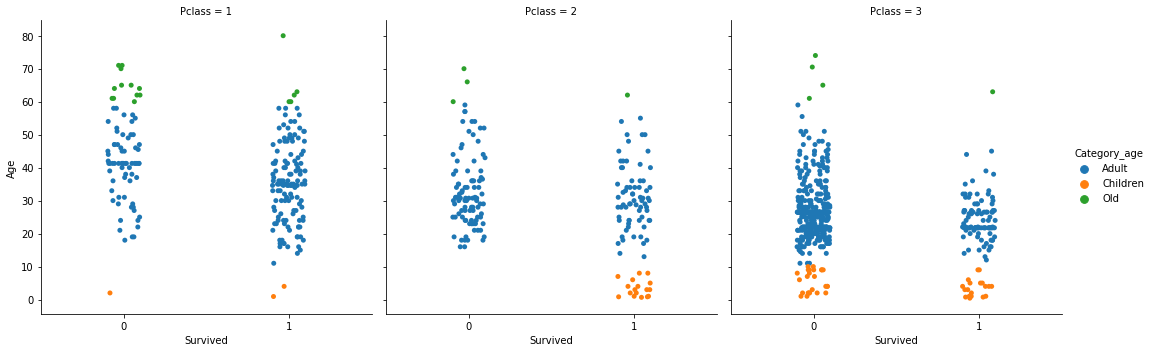

In [19]:
sns.catplot(x='Survived', y='Age', data=trainDF, hue='Category_age', col='Pclass');

### Have Family

A variável 'Have_family' irá indicar se o passageiro possuia família a bordo do navio. Serão usadas as variáveis 'SibSp' e 'Parch' que representam a quantidade de irmãos ou cônjuge e pais ou filhos, respectivamente.

In [20]:
def haveFamily(row):
    if row['SibSp']>0 or row['Parch']>0:
        return 1
    else:
        return 0

In [21]:
trainDF['Have_family'] = trainDF.apply(haveFamily, axis=1)
trainDF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Category_age,Have_family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Unknow,S,Adult,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S,Adult,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Adult,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Unknow,S,Adult,0


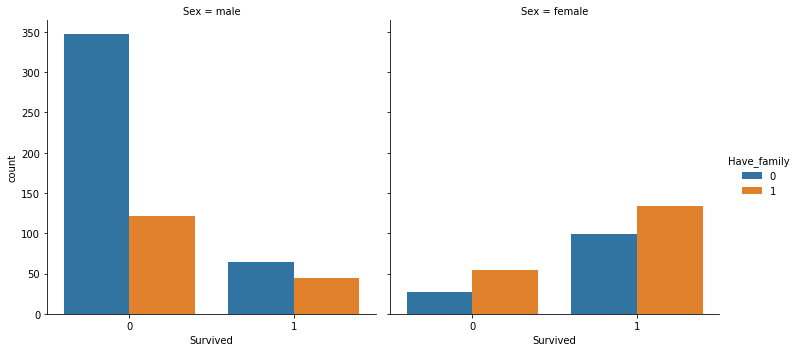

In [22]:
sns.catplot(x='Survived', hue='Have_family', col="Sex", data=trainDF, kind='count');

Como podemos ver, a maioria das pessoas que não sobreviveram ao naufrágio eram homens que não tinham familiares a bordo.

### Title

Agora vamos extrair o título do nome das pessoas ('Mr. Jhon' => 'Mr.') e entender qual a relação dessa nova variável com o restante dos dados.

In [23]:
def getTitle(name):
    '''Esta função busca em cada nome todas as letras que são seguidas por um ponto ('.') no final.
        Em seguida retira a pontuação no fim da palavra'''
    
    pattern = '[a-zA-Z]*\.'
    title = re.findall(pattern, name)[0] #findall retorna uma lista. Só queremos o 1º termo encontrado
    title = title.strip('.')
    return title

In [24]:
trainDF['Title'] = trainDF['Name'].map(getTitle)
trainDF.drop('Name', axis=1, inplace=True)
trainDF.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Category_age,Have_family,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,Unknow,S,Adult,1,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Adult,1,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,Unknow,S,Adult,0,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Adult,1,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,Unknow,S,Adult,0,Mr


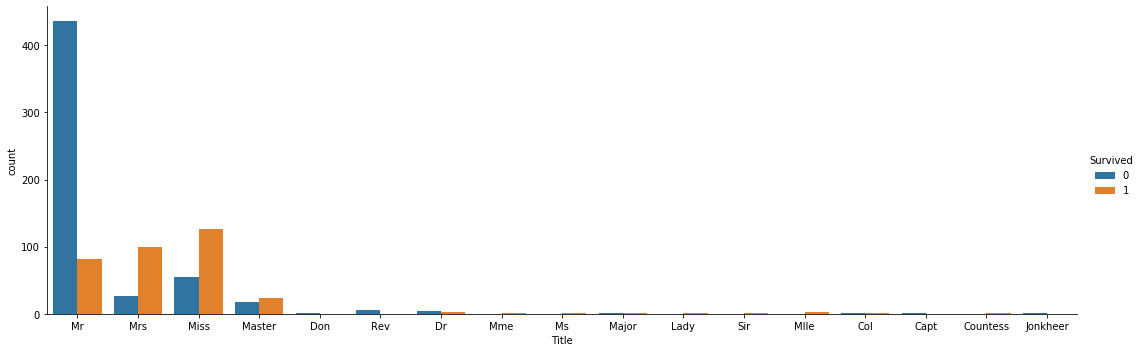

In [25]:
sns.catplot(x='Title', hue='Survived', data=trainDF, kind='count', aspect=3);

Nota-se que a maioria dos títulos não possuem exemplos suficientes, o que pode prejudicar a performance do modelo. Então, vamos agrupar os títulos. Já sabemos que a marioria das mulheres sobreviveram, por este motivo vamos agrupar os títulos femininos em um só (Miss/Mrs/Ms). No caso dos títulos masculinos, note que os títulos que não possuem muitos exemplares são títulos de nobreza, doutores, militares e religiosos (Dr/Military/Noble/Clergy). Os demais grupos serão 'Mr' e 'Master'.

In [26]:
trainDF['Title'] = trainDF['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'Countess', 'Dona'],
                                                     'Miss/Mrs/Ms')

trainDF['Title'] = trainDF['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'],
                                                     'Dr/Military/Noble/Clergy')

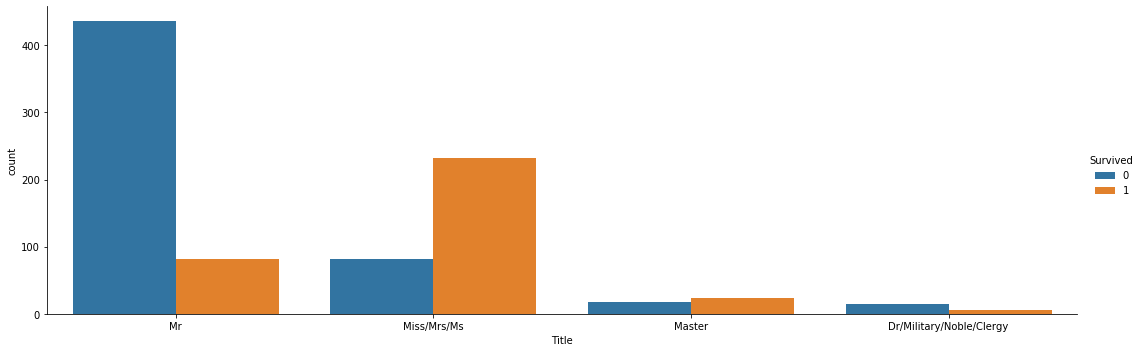

In [27]:
sns.catplot(x='Title', hue='Survived', data=trainDF, kind='count', aspect=3);

### Deck

Essa variável será extraída da variável 'Cabin'. As letras em 'Cabin' indicam o Deck onde acabine está. Como podemos observar na figura abaixo, existem cabines que estão mais próximas dos botes salva vidas.

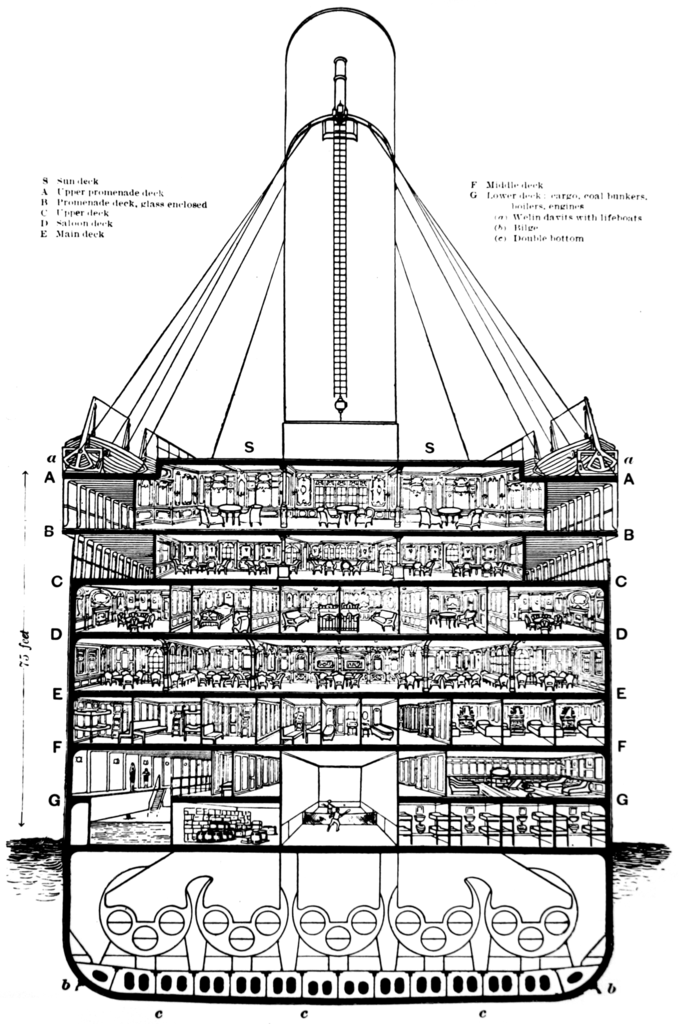

In [28]:
Image('Images/TitanicDeck.png')

In [29]:
trainDF['Deck'] = trainDF['Cabin'].map(lambda cabin : re.findall('[a-zA-Z]', cabin)[0])
trainDF.drop('Cabin', axis=1, inplace=True)
trainDF.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Category_age,Have_family,Title,Deck
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S,Adult,1,Mr,U
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C,Adult,1,Miss/Mrs/Ms,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,Adult,0,Miss/Mrs/Ms,U
3,4,1,1,female,35.0,1,0,113803,53.1000,S,Adult,1,Miss/Mrs/Ms,C
4,5,0,3,male,35.0,0,0,373450,8.0500,S,Adult,0,Mr,U


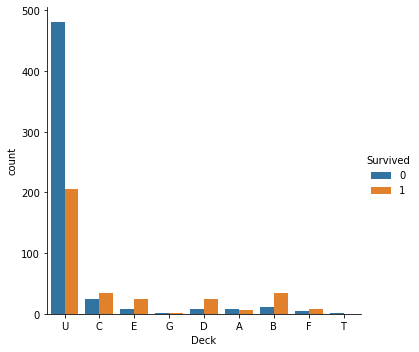

In [30]:
sns.catplot(x='Deck', hue='Survived', data=trainDF, kind='count');

Note que dentre os Decks conhecidos, os passageiros que estavam nos Decks B,C,D ou E tiveram mais chances de sobreviver.

### Fare

Vamos categorizar o preço das passagens em 10 grupos de preços.

In [31]:
trainDF['Fare'] = pd.qcut(trainDF['Fare'], 10)
trainDF.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Category_age,Have_family,Title,Deck
0,1,0,3,male,22.0,1,0,A/5 21171,"(-0.001, 7.55]",S,Adult,1,Mr,U
1,2,1,1,female,38.0,1,0,PC 17599,"(39.688, 77.958]",C,Adult,1,Miss/Mrs/Ms,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,"(7.854, 8.05]",S,Adult,0,Miss/Mrs/Ms,U
3,4,1,1,female,35.0,1,0,113803,"(39.688, 77.958]",S,Adult,1,Miss/Mrs/Ms,C
4,5,0,3,male,35.0,0,0,373450,"(7.854, 8.05]",S,Adult,0,Mr,U


## Pré-processamento dos dados

Vamos remover as variáveis que não serão usadas.

In [32]:
trainDF.drop(['PassengerId', 'SibSp', 'Parch', 'Ticket', 'Age', 'Embarked'], axis=1, inplace=True)
trainDF.head()

,Survived,Pclass,Sex,Fare,Category_age,Have_family,Title,Deck
0,0,3,male,"(-0.001, 7.55]",Adult,1,Mr,U
1,1,1,female,"(39.688, 77.958]",Adult,1,Miss/Mrs/Ms,C
2,1,3,female,"(7.854, 8.05]",Adult,0,Miss/Mrs/Ms,U
3,1,1,female,"(39.688, 77.958]",Adult,1,Miss/Mrs/Ms,C
4,0,3,male,"(7.854, 8.05]",Adult,0,Mr,U


Por fim, vamos codificar nossas variáveis para que nosso modelo possa ser mais preciso.

In [33]:
non_numeric_features = ['Pclass', 'Sex', 'Deck', 'Title', 'Have_family', 'Category_age', 'Fare']

for feature in non_numeric_features:        
     trainDF[feature] = LabelEncoder().fit_transform(trainDF[feature])

In [34]:
trainDF.head()

,Survived,Pclass,Sex,Fare,Category_age,Have_family,Title,Deck
0,0,2,1,0,0,1,3,8
1,1,0,0,8,0,1,2,2
2,1,2,0,2,0,0,2,8
3,1,0,0,8,0,1,2,2
4,0,2,1,2,0,0,3,8


## Treinamento e validação do modelo

### Variável alvo x variáveis preditoras

In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
x=trainDF[['Pclass', 'Sex', 'Title', 'Deck', 'Have_family', 'Category_age', 'Fare']]
y=trainDF['Survived']

### Importação dos modelos

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

### Seleção do modelo

In [38]:

n_folds = 10

# Lista de modelos
models = []
models.append(('DecTree', DecisionTreeClassifier()))
models.append(('NaiveB', GaussianNB()))
models.append(('LogReg', LogisticRegression()))

# Resultado dos modelos
results = []
names = []

for name, model in models:
    kfold = KFold(n_folds)
    cross_valid_result = cross_val_score(model, x, y, cv=kfold, scoring='accuracy')
    results.append(cross_valid_result)
    names.append(name)
    print('{0}: {1} ({2})'.format(name, cross_valid_result.mean(), cross_valid_result.std()))
    

DecTree: 0.8104119850187266 (0.04281139710311536)
NaiveB: 0.7363420724094882 (0.04679341754082237)
LogReg: 0.7844943820224718 (0.03483436015478116)


Como podemos observar, o modelo de Árvore de Decisão é ligeiramente melhor que os demais, por isso iremos usá-lo.

### Treinando e salvando o modelo

In [39]:
import pickle
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)
print(tree_model.score(x_test, y_test))

with open('Models\Tree.sav', 'wb') as output_model:
    pickle.dump(tree_model, output_model)

0.8507462686567164


Como podemos observar, nosso modelo foi capaz de atingir uma acurácia de pouco mais de 85%. O que se demonstra satisfatório diante do nosso objetivo inicial de 80%.